Python Threat Hunting Tools: Part 11 – A Jupyter Notebook for MISP


In [ ]:
#!pip3 install --upgrade pymisp
from pymisp import PyMISP
from pprint import pprint
import matplotlib_inline
import pandas as pd
import urllib3
from urllib3.exceptions import InsecureRequestWarning
# disable ssl warnings
urllib3.disable_warnings(InsecureRequestWarning)

# create MISP instance
MISP_URL = 'https://localhost'
MISP_API_KEY = 'XRXFHOwNFiMQxu1bdgPL63ifWjvLTlH5cVdSv0M7'
misp = PyMISP(MISP_URL, MISP_API_KEY, ssl=False, debug=False)

In [127]:
# Malicious IP Address Checker

#!pip3 install maltiverse
from maltiverse import Maltiverse

IP = "171.61.223.122"

api = Maltiverse()
result = api.ip_get(IP)
try:
    print(f"\n=> The IP address {IP} has been identified as {result['classification']} by Maltiverse\n")
except KeyError:
    print(f"\n - The IP address {IP} cannot be classified by Maltiverse\n")


=> The IP address 171.61.223.122 has been identified as suspicious by Maltiverse



In [132]:
# Searching for IOCs in MISP instance
IOC = "www.goodle.cyou"

def search_ioc():
    try:
        response = requests.post(
            f"{MISP_URL}/attributes/restSearch",            # MUST be https://
            headers={
                'Authorization': MISP_API_KEY,
                'Content-Type': 'application/json',
                'Accept': 'application/json'
            },
            json={
                "returnFormat": "json",
                "value": IOC
            },
            verify=False,
            timeout=10
        )

        # Process response
        if response.status_code == 200:
            results = response.json()
            if results.get('response', {}).get('Attribute'):
                print(f"Found {len(results['response']['Attribute'])} matches:")
                for attr in results['response']['Attribute']:
                    print(f"\nType: {attr.get('type')}")
                    print(f"Value: {attr.get('value')}")
                    print(f"Event ID: {attr.get('event_id')}")
                    print(f"Category: {attr.get('category')}")
                    if attr.get('to_ids'):
                        print("Marked for IDS: Yes")
            else:
                print("No matches found")
        else:
            print(f"Error {response.status_code}: {response.text}")

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {str(e)}")
    except json.JSONDecodeError:
        print("Invalid JSON response. Raw output:")
        print(response.text)

# Execute
search_ioc()

Found 2 matches:

Type: domain
Value: www.goodle.cyou
Event ID: 6469
Category: Network activity
Marked for IDS: Yes

Type: hostname
Value: www.goodle.cyou
Event ID: 742
Category: Network activity
Marked for IDS: Yes


In [135]:
# Verified Solution (from MISP core team) for the API call POST strict requirements by MISP, which is a safety update after version MISP 2.4.160+
import requests

response = requests.post(
    f"{MISP_URL}/attributes/restSearch", 
    headers={
        'Authorization': MISP_API_KEY,
        'Content-Type': 'application/json',
        'Accept': 'application/json'  # Required for MISP ≥2.4.160
    },
    json={  # Must be exact format
        "returnFormat": "json",
        "value": "snitch2025.pagekite.me"
    },
    verify=False
)

print(response.status_code)
print(response.json())

200
{'response': {'Attribute': [{'id': '5886198', 'event_id': '7259', 'object_id': '0', 'object_relation': None, 'category': 'Network activity', 'type': 'domain', 'to_ids': True, 'uuid': 'b19a1566-665c-11f0-851c-42010aa4000a', 'timestamp': '1753120875', 'distribution': '5', 'sharing_group_id': '0', 'comment': 'NjRAT botnet C2 domain (confidence level: 100%)', 'deleted': False, 'disable_correlation': False, 'first_seen': None, 'last_seen': None, 'value': 'snitch2025.pagekite.me', 'Event': {'id': '7259', 'info': 'ThreatFox IOCs for 2025-07-21', 'org_id': '1', 'orgc_id': '10', 'uuid': '120c6a2c-0089-48b4-b722-8f9dd10244ef', 'user_id': '1', 'distribution': '0', 'publish_timestamp': '1753544174'}, 'Tag': [{'id': '1052', 'name': 'c2', 'colour': '#b6b48d', 'numerical_value': None, 'is_galaxy': False, 'local': False}, {'id': '1318', 'name': 'domain', 'colour': '#5025EF', 'numerical_value': None, 'is_galaxy': False, 'local': False}, {'id': '820', 'name': 'njrat', 'colour': '#EB13BD', 'numerical

In [13]:
# General statistics

def general_statistics():
    res = misp.users_statistics()
    print("--- General Stats ---")
    print(f"Users: {res['stats']['user_count']}")
    print(f"Events: {res['stats']['event_count']}")
    print(f"- added this month: {res['stats']['event_count_month']}")
    print(f"Attributes: {res['stats']['attribute_count']}")
    print(f"- added this month: {res['stats']['attribute_count_month']}")
    print()

general_statistics()

--- General Stats ---
Users: 2
Events: 8166
- added this month: 308
Attributes: 11520889
- added this month: 1574570



In [27]:
# Tag statistics

def tag_statistics():
    res = misp.tags_statistics()
    print("--- Tag Stats ---")
    print(f"Threat Intelligence Articles: " + res['tags']['osint:source-type="technical-report"'])  # updated tag description as per latest MISP documentation
    print(f"Manual Investigation: " + res['tags']['osint:source-type="manual-analysis"'])
    print(f"Malware Research: " + res['tags']['circl:incident-classification="malware"'])
    print()

tag_statistics()

--- Tag Stats ---
Threat Intelligence Articles: 20
Manual Investigation: 1
Malware Research: 204



In [ ]:
# Fixed Tag statistics function as test

def tag_statistics():
    res = misp.tags_statistics()
    print("--- Tag Stats ---")
    
    # First, let's see what structure we get back
    print("Response structure:")
    if isinstance(res, dict):
        print(f"Keys available: {list(res.keys())}")
        
        # Check if 'tags' key exists and what's inside
        if 'tags' in res:
            print(f"Tags structure: {type(res['tags'])}")
            if isinstance(res['tags'], dict):
                print(f"Available tag keys: {list(res['tags'].keys())[:10]}...")  # Show first 10
            
        # Method 1: Safe access with get() method
        print("\n--- Safe Tag Counts ---")
        threat_intel = res.get('tags', {}).get('cssa:origin="report"', 0)
        manual_investigation = res.get('tags', {}).get('cssa:origin="manual_investigation"', 0)
        past_incident = res.get('tags', {}).get('past-incident', 0)
        malware_research = res.get('tags', {}).get('software-research', 0)
        
        print(f"Threat Intelligence Articles: {threat_intel}")
        print(f"Manual Investigation: {manual_investigation}")
        print(f"Past Incident: {past_incident}")
        print(f"Malware Research: {malware_research}")
        
        # Method 2: Iterate through all tags and show counts
        print("\n--- All Available Tags ---")
        if 'tags' in res and isinstance(res['tags'], dict):
            for tag_name, count in res['tags'].items():
                print(f"{tag_name}: {count}")
                
    else:
        print(f"Unexpected response type: {type(res)}")
        print(f"Response content: {res}")
    
    print()

# Alternative function that handles the response more robustly
def safe_tag_statistics():
    try:
        res = misp.tags_statistics()
        print("--- Safe Tag Stats ---")
        
        # Handle different possible response structures
        tags_data = None
        if isinstance(res, dict):
            if 'tags' in res:
                tags_data = res['tags']
            elif 'response' in res and 'tags' in res['response']:
                tags_data = res['response']['tags']
            else:
                # Sometimes the response is directly the tags data
                tags_data = res
        
        if tags_data and isinstance(tags_data, dict):
            # Look for your specific tags with exact matching
            target_tags = [
                'cssa:origin="report"',
                'cssa:origin="manual_investigation"', 
                'past-incident',
                'software-research'
            ]
            
            print("Searching for specific tags:")
            for tag in target_tags:
                count = tags_data.get(tag, 0)
                print(f"{tag}: {count}")
            
            # Also show all available tags that contain your keywords
            print("\nAll tags containing 'cssa', 'past', or 'software':")
            for tag_name, count in tags_data.items():
                if any(keyword in tag_name.lower() for keyword in ['cssa', 'past', 'software', 'report', 'manual']):
                    print(f"{tag_name}: {count}")
                    
        else:
            print("Could not find tags data in response")
            print(f"Response: {res}")
            
    except Exception as e:
        print(f"Error in safe_tag_statistics: {e}")
        print(f"Error type: {type(e)}")

# Enhanced function that also searches for partial matches
def enhanced_tag_statistics():
    try:
        res = misp.tags_statistics()
        print("--- Enhanced Tag Stats ---")
        
        # Get tags data from response
        tags_data = res.get('tags', {}) if isinstance(res, dict) and 'tags' in res else res
        
        if isinstance(tags_data, dict):
            # Define search patterns for your tags
            search_patterns = {
                'Threat Intelligence Reports': ['cssa:origin', 'report'],
                'Manual Investigations': ['manual', 'investigation'], 
                'Past Incidents': ['past', 'incident'],
                'Malware Research': ['software', 'research', 'malware']
            }
            
            for category, patterns in search_patterns.items():
                print(f"\n{category}:")
                found_tags = []
                
                for tag_name, count in tags_data.items():
                    if all(pattern in tag_name.lower() for pattern in patterns):
                        found_tags.append((tag_name, count))
                
                if found_tags:
                    for tag_name, count in found_tags:
                        print(f"  {tag_name}: {count}")
                else:
                    print(f"  No tags found matching patterns: {patterns}")
                    
            # Show total count
            total_tags = len(tags_data)
            print(f"\nTotal unique tags: {total_tags}")
            
        else:
            print("Tags data is not in expected dictionary format")
            print(f"Data type: {type(tags_data)}")
            
    except Exception as e:
        print(f"Error in enhanced_tag_statistics: {e}")

# Call the functions
tag_statistics()
safe_tag_statistics() 
enhanced_tag_statistics()

--- Tag Stats ---
Response structure:
Keys available: ['tags', 'taxonomies']
Tags structure: <class 'dict'>
Available tag keys: ['tlp:white', 'tlp:clear', 'type:OSINT', 'osint:lifetime="perpetual"', 'hive pro', 'osint:source-type="blog-post"', 'osint:certainty="50"', 'circl:incident-classification="malware"', 'cybersec sentinel', 'ahnlab security intelligence center']...

--- Safe Tag Counts ---
Threat Intelligence Articles: 0
Manual Investigation: 0
Past Incident: 0
Malware Research: 0

--- All Available Tags ---
tlp:white: 4324
tlp:clear: 3827
type:OSINT: 3280
osint:lifetime="perpetual": 283
hive pro: 281
osint:source-type="blog-post": 274
osint:certainty="50": 219
circl:incident-classification="malware": 204
cybersec sentinel: 176
ahnlab security intelligence center: 159
polyswarm: 124
malware_classification:malware-category="Ransomware": 99
ecsirt:malicious-code="ransomware": 90
trend micro: 86
cyfirma: 82
cyble: 79
tlp:green: 76
fortinet: 75
talos: 74
securelist: 70
misp-galaxy:ma

In [29]:
# Simple function to search for specific patterns
def search_tags_by_pattern(search_terms):
    res = misp.tags_statistics()
    tags_data = res.get('tags', {})
    
    print(f"--- Searching for tags containing: {search_terms} ---")
    
    if isinstance(search_terms, str):
        search_terms = [search_terms]
    
    found_tags = []
    for tag_name, count in tags_data.items():
        if any(term.lower() in tag_name.lower() for term in search_terms):
            found_tags.append((tag_name, count))
    
    # Sort by count (descending)
    found_tags.sort(key=lambda x: x[1], reverse=True)
    
    for tag_name, count in found_tags:
        print(f"{tag_name}: {count}")
    
    if not found_tags:
        print("No tags found matching your search terms")
    
    return found_tags

# Example searches based on what you might be looking for:
print("\n" + "="*50)
search_tags_by_pattern(['malware', 'ransomware'])
print("\n" + "="*50)
search_tags_by_pattern(['incident', 'classification'])
print("\n" + "="*50)
search_tags_by_pattern(['source-type'])


--- Searching for tags containing: ['malware', 'ransomware'] ---
malware_classification:malware-category="Ransomware": 99
ecsirt:malicious-code="ransomware": 90
veris:action:malware:variety="Ransomware": 9
ecsirt:malicious-code="malware": 8
enisa:nefarious-activity-abuse="mobile-malware": 8
ms-caro-malware:malware-type="Backdoor": 8
misp-galaxy:mitre-malware="PlugX - S0013": 7
misp-galaxy:ransomware="CryptoMix": 7
ms-caro-malware-full:malware-type="Backdoor": 7
veris:action:malware:variety="Backdoor": 7
dnc:malware-type="Ransomware": 6
Android Malware: 6
misp-galaxy:ransomware="Fake Globe Ransomware": 6
misp-galaxy:ransomware="Samas-Samsam": 6
misp-galaxy:ransomware="Locky": 58
Ransomware: 5
misp-galaxy:ransomware="WannaCry": 5
misp-galaxy:ransomware="Bad Rabbit": 5
ms-caro-malware-full:malware-type="RemoteAccess": 5
misp-galaxy:ransomware="Ryuk ransomware": 5
misp-galaxy:mitre-attack-pattern="Malware - T1587.001": 4
ms-caro-malware:malware-platform="Win32": 4
ms-caro-malware:malware-

[('osint:source-type="pastie-website"', '8'),
 ('osint:source-type="block-or-filter-list"', '51'),
 ('osint:source-type="source-code-repository"', '3'),
 ('osint:source-type="blog-post"', '274'),
 ('osint:source-type="technical-report"', '20'),
 ('osint:source-type="automatic-collection"', '2'),
 ('osint:source-type="microblog-post"', '17'),
 ('osint:source-type="automatic-analysis"', '1'),
 ('osint:source-type="manual-analysis"', '1')]

In [33]:
# Tag statistics in current MISP instance
def MISP_tag_statistics():
    res = misp.tags_statistics()
    print("--- MISP Actual Tag Statistics ---")
    
    tags_data = res.get('tags', {})
    
    # Categories based on your actual tags
    categories = {
        'TLP Classifications': ['tlp:'],
        'OSINT Sources': ['osint:', 'type:OSINT'],
        'Threat Intelligence Platforms': ['hive pro', 'cybersec sentinel', 'ahnlab', 'polyswarm'],
        'Malware Classifications': ['malware_classification:', 'circl:incident-classification="malware"'],
        'Source Types': ['osint:source-type='],
        'Certainty Levels': ['osint:certainty='],
        'Lifetime Classifications': ['osint:lifetime=']
    }
    
    for category, patterns in categories.items():
        print(f"\n{category}:")
        category_tags = []
        
        for tag_name, count in tags_data.items():
            if any(pattern in tag_name.lower() for pattern in patterns):
                category_tags.append((tag_name, count))
        
        # Sort by count (descending)
        category_tags.sort(key=lambda x: x[1], reverse=True)
        
        # Show top 5 in each category
        for tag_name, count in category_tags[:5]:
            print(f"  {tag_name}: {count}")
        
        if len(category_tags) > 5:
            print(f"  ... and {len(category_tags) - 5} more")
    
    # Show top 10 most used tags overall
    print(f"\n--- Top 10 Most Used Tags ---")
    all_tags = [(name, count) for name, count in tags_data.items()]
    all_tags.sort(key=lambda x: x[1], reverse=True)
    
    for tag_name, count in all_tags[:10]:
        print(f"{tag_name}: {count}")
    
    print(f"\nTotal unique tags: {len(tags_data)}")
    #print(f"Total tag usage: {sum(tags_data.values())}")

MISP_tag_statistics()

--- MISP Actual Tag Statistics ---

TLP Classifications:
  tlp:green: 76
  tlp:white: 4502
  tlp:clear: 3827
  tlp:amber: 1

OSINT Sources:
  osint:source-type="pastie-website": 8
  osint:source-type="block-or-filter-list": 51
  osint:certainty="75": 5
  osint:source-type="source-code-repository": 3
  osint:lifetime="perpetual": 283
  ... and 9 more

Threat Intelligence Platforms:
  hive pro: 281
  cybersec sentinel: 176
  ahnlab security intelligence center: 159
  polyswarm: 124

Malware Classifications:
  malware_classification:malware-category="Ransomware": 99
  	malware_classification:malware-category="Botnet": 4
  malware_classification:malware-category="Spyware": 3
  malware_classification:malware-category="Rootkit": 3
  circl:incident-classification="malware": 204
  ... and 5 more

Source Types:
  osint:source-type="pastie-website": 8
  osint:source-type="block-or-filter-list": 51
  osint:source-type="source-code-repository": 3
  osint:source-type="blog-post": 274
  osint:source

In [36]:
# Attribute statistics

def attribute_statistics():
    res = misp.attributes_statistics()
    print("--- Attribute Stats ---")
    values_all = list(res.values())
    total_all = 0
    for i in values_all:
        total_all += int(i)
    print(f"Total: {total_all}")
    print("-" * 50)

    total_endpoint = int(res['md5']) + int(res['sha1']) + int(res['sha256'])
    print(f"Endpoint Indicators: {total_endpoint}")
    print(f"- MD5 hash: {res['md5']}")
    print(f"- SHA1 hash: {res['sha1']}")
    print(f"- SHA256 hash: {res['sha256']}")
    print("-" * 50)

    total_network = int(res['domain']) + int(res['ip-dst']) + int(res['hostname']) + int(res['url']) + int(res['email-src'])
    print(f"Network Indicators: {total_network}")
    print(f"- Domains: {res['domain']}")
    print(f"- IP addresses: {res['ip-dst']}")
    print(f"- Hostnames: {res['hostname']}")
    print(f"- URLs: {res['url']}")
    print(f"- Email addresses: {res['email-src']}")

attribute_statistics()

--- Attribute Stats ---
Total: 14159659
--------------------------------------------------
Endpoint Indicators: 4099153
- MD5 hash: 1435767
- SHA1 hash: 486741
- SHA256 hash: 2176645
--------------------------------------------------
Network Indicators: 3031101
- Domains: 818893
- IP addresses: 1210981
- Hostnames: 121211
- URLs: 879353
- Email addresses: 663


Fetched 1000 events from page 1
Top TTP Counts: {'T1566.001': 23, 'T1566': 22, 'T1071.001': 18, 'T1059.001': 17, 'T1082': 16, 'T1190': 15, 'T1140': 14, 'T1566.002': 14, 'T1057': 14, 'T1547.001': 13}


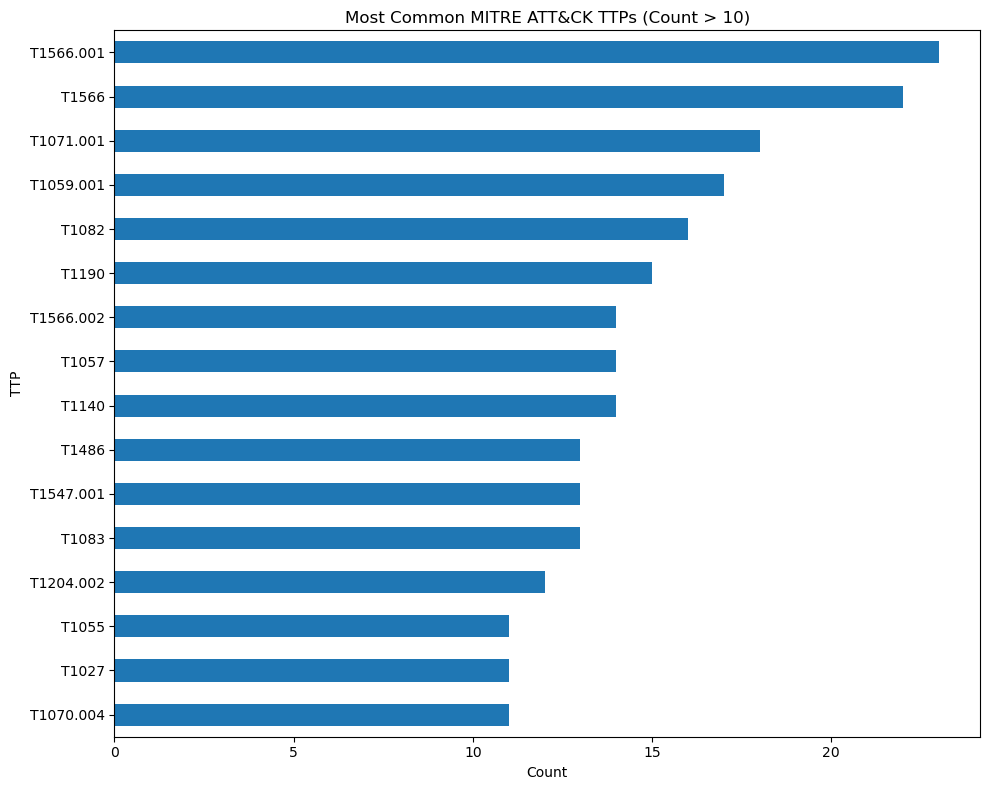

In [6]:
# Find the most common TTPs
import pandas as pd
import matplotlib.pyplot as plt

# define filters
filters = {
    'published': True,
    'threat_level_id': [1,2],
    'limit': 1000,
    'page': 1
}

# get all events in MISP instance
all_events = []
while True:
    try:
        events = misp.search(cotroller="events", **filters)
        if not events:
            break
        all_events.extend(events)
        print(f"Fetched {len(events)} events from page {filters['page']}")
        filters['page'] += 1
        if len(all_events) >= 1000:     # use filter again to control event data ingestion for execution optimization
            break
    except Exception as e:
        print(f"Error fetching events on page {filters['page']}: {e}")
        break

ttps = {                # create a dictionary containing all MITRE ATT&CK TTPs
    "T1548" : 0,
    "T1548.002" : 0,
    "T1548.004" : 0,
    "T1548.001" : 0,
    "T1548.003" : 0,
    "T1134" : 0,
    "T1134.002" : 0,
    "T1134.003" : 0,
    "T1134.004" : 0,
    "T1134.005" : 0,
    "T1134.001" : 0,
    "T1531" : 0,
    "T1087" : 0,
    "T1087.004" : 0,
    "T1087.002" : 0,
    "T1087.003" : 0,
    "T1087.001" : 0,
    "T1098" : 0,
    "T1098.001" : 0,
    "T1098.003" : 0,
    "T1098.002" : 0,
    "T1098.005" : 0,
    "T1098.004" : 0,
    "T1650" : 0,
    "T1583" : 0,
    "T1583.005" : 0,
    "T1583.002" : 0,
    "T1583.001" : 0,
    "T1583.008" : 0,
    "T1583.004" : 0,
    "T1583.007" : 0,
    "T1583.003" : 0,
    "T1583.006" : 0,
    "T1595" : 0,
    "T1595.001" : 0,
    "T1595.002" : 0,
    "T1595.003" : 0,
    "T1557" : 0,
    "T1557.002" : 0,
    "T1557.003" : 0,
    "T1557.001" : 0,
    "T1071" : 0,
    "T1071.004" : 0,
    "T1071.002" : 0,
    "T1071.003" : 0,
    "T1071.001" : 0,
    "T1010" : 0,
    "T1560" : 0,
    "T1560.003" : 0,
    "T1560.002" : 0,
    "T1560.001" : 0,
    "T1123" : 0,
    "T1119" : 0,
    "T1020" : 0,
    "T1020.001" : 0,
    "T1197" : 0,
    "T1547" : 0,
    "T1547.014" : 0,
    "T1547.002" : 0,
    "T1547.006" : 0,
    "T1547.008" : 0,
    "T1547.015" : 0,
    "T1547.010" : 0,
    "T1547.012" : 0,
    "T1547.007" : 0,
    "T1547.001" : 0,
    "T1547.005" : 0,
    "T1547.009" : 0,
    "T1547.003" : 0,
    "T1547.004" : 0,
    "T1547.013" : 0,
    "T1037" : 0,
    "T1037.002" : 0,
    "T1037.001" : 0,
    "T1037.003" : 0,
    "T1037.004" : 0,
    "T1037.005" : 0,
    "T1176" : 0,
    "T1217" : 0,
    "T1185" : 0,
    "T1110" : 0,
    "T1110.004" : 0,
    "T1110.002" : 0,
    "T1110.001" : 0,
    "T1110.003" : 0,
    "T1612" : 0,
    "T1115" : 0,
    "T1651" : 0,
    "T1580" : 0,
    "T1538" : 0,
    "T1526" : 0,
    "T1619" : 0,
    "T1059" : 0,
    "T1059.002" : 0,
    "T1059.009" : 0,
    "T1059.007" : 0,
    "T1059.008" : 0,
    "T1059.001" : 0,
    "T1059.006" : 0,
    "T1059.004" : 0,
    "T1059.005" : 0,
    "T1059.003" : 0,
    "T1092" : 0,
    "T1586" : 0,
    "T1586.003" : 0,
    "T1586.002" : 0,
    "T1586.001" : 0,
    "T1554" : 0,
    "T1584" : 0,
    "T1584.005" : 0,
    "T1584.002" : 0,
    "T1584.001" : 0,
    "T1584.004" : 0,
    "T1584.007" : 0,
    "T1584.003" : 0,
    "T1584.006" : 0,
    "T1609" : 0,
    "T1613" : 0,
    "T1136" : 0,
    "T1136.003" : 0,
    "T1136.002" : 0,
    "T1136.001" : 0,
    "T1543" : 0,
    "T1543.001" : 0,
    "T1543.004" : 0,
    "T1543.002" : 0,
    "T1543.003" : 0,
    "T1555" : 0,
    "T1555.003" : 0,
    "T1555.001" : 0,
    "T1555.005" : 0,
    "T1555.002" : 0,
    "T1555.004" : 0,
    "T1485" : 0,
    "T1132" : 0,
    "T1132.002" : 0,
    "T1132.001" : 0,
    "T1486" : 0,
    "T1565" : 0,
    "T1565.003" : 0,
    "T1565.001" : 0,
    "T1565.002" : 0,
    "T1001" : 0,
    "T1001.001" : 0,
    "T1001.003" : 0,
    "T1001.002" : 0,
    "T1074" : 0,
    "T1074.001" : 0,
    "T1074.002" : 0,
    "T1030" : 0,
    "T1530" : 0,
    "T1602" : 0,
    "T1602.002" : 0,
    "T1602.001" : 0,
    "T1213" : 0,
    "T1213.003" : 0,
    "T1213.001" : 0,
    "T1213.002" : 0,
    "T1005" : 0,
    "T1039" : 0,
    "T1025" : 0,
    "T1622" : 0,
    "T1491" : 0,
    "T1491.002" : 0,
    "T1491.001" : 0,
    "T1140" : 0,
    "T1610" : 0,
    "T1587" : 0,
    "T1587.002" : 0,
    "T1587.003" : 0,
    "T1587.004" : 0,
    "T1587.001" : 0,
    "T1652" : 0,
    "T1006" : 0,
    "T1561" : 0,
    "T1561.001" : 0,
    "T1561.002" : 0,
    "T1484" : 0,
    "T1484.002" : 0,
    "T1484.001" : 0,
    "T1482" : 0,
    "T1189" : 0,
    "T1568" : 0,
    "T1568.003" : 0,
    "T1568.002" : 0,
    "T1568.001" : 0,
    "T1114" : 0,
    "T1114.003" : 0,
    "T1114.001" : 0,
    "T1114.002" : 0,
    "T1573" : 0,
    "T1573.002" : 0,
    "T1573.001" : 0,
    "T1499" : 0,
    "T1499.003" : 0,
    "T1499.004" : 0,
    "T1499.001" : 0,
    "T1499.002" : 0,
    "T1611" : 0,
    "T1585" : 0,
    "T1585.003" : 0,
    "T1585.002" : 0,
    "T1585.001" : 0,
    "T1546" : 0,
    "T1546.008" : 0,
    "T1546.009" : 0,
    "T1546.010" : 0,
    "T1546.011" : 0,
    "T1546.001" : 0,
    "T1546.015" : 0,
    "T1546.014" : 0,
    "T1546.012" : 0,
    "T1546.016" : 0,
    "T1546.006" : 0,
    "T1546.007" : 0,
    "T1546.013" : 0,
    "T1546.002" : 0,
    "T1546.005" : 0,
    "T1546.004" : 0,
    "T1546.003" : 0,
    "T1480" : 0,
    "T1480.001" : 0,
    "T1048" : 0,
    "T1048.002" : 0,
    "T1048.001" : 0,
    "T1048.003" : 0,
    "T1041" : 0,
    "T1011" : 0,
    "T1011.001" : 0,
    "T1052" : 0,
    "T1052.001" : 0,
    "T1567" : 0,
    "T1567.002" : 0,
    "T1567.001" : 0,
    "T1567.003" : 0,
    "T1190" : 0,
    "T1203" : 0,
    "T1212" : 0,
    "T1211" : 0,
    "T1068" : 0,
    "T1210" : 0,
    "T1133" : 0,
    "T1008" : 0,
    "T1083" : 0,
    "T1222" : 0,
    "T1222.002" : 0,
    "T1222.001" : 0,
    "T1495" : 0,
    "T1187" : 0,
    "T1606" : 0,
    "T1606.002" : 0,
    "T1606.001" : 0,
    "T1592" : 0,
    "T1592.004" : 0,
    "T1592.003" : 0,
    "T1592.001" : 0,
    "T1592.002" : 0,
    "T1589" : 0,
    "T1589.001" : 0,
    "T1589.002" : 0,
    "T1589.003" : 0,
    "T1590" : 0,
    "T1590.002" : 0,
    "T1590.001" : 0,
    "T1590.005" : 0,
    "T1590.006" : 0,
    "T1590.004" : 0,
    "T1590.003" : 0,
    "T1591" : 0,
    "T1591.002" : 0,
    "T1591.001" : 0,
    "T1591.003" : 0,
    "T1591.004" : 0,
    "T1615" : 0,
    "T1200" : 0,
    "T1564" : 0,
    "T1564.008" : 0,
    "T1564.005" : 0,
    "T1564.001" : 0,
    "T1564.002" : 0,
    "T1564.003" : 0,
    "T1564.004" : 0,
    "T1564.010" : 0,
    "T1564.009" : 0,
    "T1564.006" : 0,
    "T1564.007" : 0,
    "T1574" : 0,
    "T1574.012" : 0,
    "T1574.001" : 0,
    "T1574.002" : 0,
    "T1574.004" : 0,
    "T1574.006" : 0,
    "T1574.005" : 0,
    "T1574.013" : 0,
    "T1574.007" : 0,
    "T1574.008" : 0,
    "T1574.009" : 0,
    "T1574.010" : 0,
    "T1574.011" : 0,
    "T1562" : 0,
    "T1562.008" : 0,
    "T1562.002" : 0,
    "T1562.007" : 0,
    "T1562.004" : 0,
    "T1562.001" : 0,
    "T1562.010" : 0,
    "T1562.003" : 0,
    "T1562.006" : 0,
    "T1562.009" : 0,
    "T1562.011" : 0,
    "T1525" : 0,
    "T1070" : 0,
    "T1070.003" : 0,
    "T1070.002" : 0,
    "T1070.008" : 0,
    "T1070.007" : 0,
    "T1070.009" : 0,
    "T1070.001" : 0,
    "T1070.004" : 0,
    "T1070.005" : 0,
    "T1070.006" : 0,
    "T1202" : 0,
    "T1105" : 0,
    "T1490" : 0,
    "T1056" : 0,
    "T1056.004" : 0,
    "T1056.002" : 0,
    "T1056.001" : 0,
    "T1056.003" : 0,
    "T1559" : 0,
    "T1559.001" : 0,
    "T1559.002" : 0,
    "T1559.003" : 0,
    "T1534" : 0,
    "T1570" : 0,
    "T1036" : 0,
    "T1036.007" : 0,
    "T1036.001" : 0,
    "T1036.008" : 0,
    "T1036.004" : 0,
    "T1036.005" : 0,
    "T1036.003" : 0,
    "T1036.002" : 0,
    "T1036.006" : 0,
    "T1556" : 0,
    "T1556.001" : 0,
    "T1556.007" : 0,
    "T1556.006" : 0,
    "T1556.004" : 0,
    "T1556.008" : 0,
    "T1556.002" : 0,
    "T1556.003" : 0,
    "T1556.005" : 0,
    "T1578" : 0,
    "T1578.002" : 0,
    "T1578.001" : 0,
    "T1578.003" : 0,
    "T1578.004" : 0,
    "T1112" : 0,
    "T1601" : 0,
    "T1601.002" : 0,
    "T1601.001" : 0,
    "T1111" : 0,
    "T1621" : 0,
    "T1104" : 0,
    "T1106" : 0,
    "T1599" : 0,
    "T1599.001" : 0,
    "T1498" : 0,
    "T1498.001" : 0,
    "T1498.002" : 0,
    "T1046" : 0,
    "T1135" : 0,
    "T1040" : 0,
    "T1095" : 0,
    "T1571" : 0,
    "T1003" : 0,
    "T1003.008" : 0,
    "T1003.005" : 0,
    "T1003.006" : 0,
    "T1003.004" : 0,
    "T1003.001" : 0,
    "T1003.003" : 0,
    "T1003.007" : 0,
    "T1003.002" : 0,
    "T1027" : 0,
    "T1027.001" : 0,
    "T1027.010" : 0,
    "T1027.004" : 0,
    "T1027.007" : 0,
    "T1027.009" : 0,
    "T1027.011" : 0,
    "T1027.006" : 0,
    "T1027.005" : 0,
    "T1027.002" : 0,
    "T1027.003" : 0,
    "T1027.008" : 0,
    "T1588" : 0,
    "T1588.003" : 0,
    "T1588.004" : 0,
    "T1588.005" : 0,
    "T1588.001" : 0,
    "T1588.002" : 0,
    "T1588.006" : 0,
    "T1137" : 0,
    "T1137.006" : 0,
    "T1137.001" : 0,
    "T1137.002" : 0,
    "T1137.003" : 0,
    "T1137.004" : 0,
    "T1137.005" : 0,
    "T1201" : 0,
    "T1120" : 0,
    "T1069" : 0,
    "T1069.003" : 0,
    "T1069.002" : 0,
    "T1069.001" : 0,
    "T1566" : 0,
    "T1598" : 0,
    "T1598.002" : 0,
    "T1598.003" : 0,
    "T1598.001" : 0,
    "T1566.001" : 0,
    "T1566.002" : 0,
    "T1566.003" : 0,
    "T1647" : 0,
    "T1542" : 0,
    "T1542.003" : 0,
    "T1542.002" : 0,
    "T1542.004" : 0,
    "T1542.001" : 0,
    "T1542.005" : 0,
    "T1057" : 0,
    "T1055" : 0,
    "T1055.004" : 0,
    "T1055.001" : 0,
    "T1055.011" : 0,
    "T1055.015" : 0,
    "T1055.002" : 0,
    "T1055.009" : 0,
    "T1055.013" : 0,
    "T1055.012" : 0,
    "T1055.008" : 0,
    "T1055.003" : 0,
    "T1055.005" : 0,
    "T1055.014" : 0,
    "T1572" : 0,
    "T1090" : 0,
    "T1090.004" : 0,
    "T1090.002" : 0,
    "T1090.001" : 0,
    "T1090.003" : 0,
    "T1012" : 0,
    "T1620" : 0,
    "T1219" : 0,
    "T1563" : 0,
    "T1563.002" : 0,
    "T1563.001" : 0,
    "T1021" : 0,
    "T1021.007" : 0,
    "T1021.003" : 0,
    "T1021.001" : 0,
    "T1021.002" : 0,
    "T1021.004" : 0,
    "T1021.005" : 0,
    "T1021.006" : 0,
    "T1018" : 0,
    "T1091" : 0,
    "T1496" : 0,
    "T1207" : 0,
    "T1014" : 0,
    "T1053" : 0,
    "T1053.002" : 0,
    "T1053.007" : 0,
    "T1053.003" : 0,
    "T1053.005" : 0,
    "T1053.006" : 0,
    "T1029" : 0,
    "T1113" : 0,
    "T1597" : 0,
    "T1597.002" : 0,
    "T1597.001" : 0,
    "T1596" : 0,
    "T1596.004" : 0,
    "T1596.001" : 0,
    "T1596.003" : 0,
    "T1596.005" : 0,
    "T1596.002" : 0,
    "T1593" : 0,
    "T1593.003" : 0,
    "T1593.002" : 0,
    "T1593.001" : 0,
    "T1594" : 0,
    "T1505" : 0,
    "T1505.004" : 0,
    "T1505.001" : 0,
    "T1505.005" : 0,
    "T1505.002" : 0,
    "T1505.003" : 0,
    "T1648" : 0,
    "T1489" : 0,
    "T1129" : 0,
    "T1072" : 0,
    "T1518" : 0,
    "T1518.001" : 0,
    "T1608" : 0,
    "T1608.004" : 0,
    "T1608.003" : 0,
    "T1608.005" : 0,
    "T1608.006" : 0,
    "T1608.001" : 0,
    "T1608.002" : 0,
    "T1528" : 0,
    "T1539" : 0,
    "T1649" : 0,
    "T1558" : 0,
    "T1558.004" : 0,
    "T1558.001" : 0,
    "T1558.003" : 0,
    "T1558.002" : 0,
    "T1553" : 0,
    "T1553.002" : 0,
    "T1553.006" : 0,
    "T1553.001" : 0,
    "T1553.004" : 0,
    "T1553.005" : 0,
    "T1553.003" : 0,
    "T1195" : 0,
    "T1195.003" : 0,
    "T1195.001" : 0,
    "T1195.002" : 0,
    "T1218" : 0,
    "T1218.003" : 0,
    "T1218.001" : 0,
    "T1218.002" : 0,
    "T1218.004" : 0,
    "T1218.014" : 0,
    "T1218.013" : 0,
    "T1218.005" : 0,
    "T1218.007" : 0,
    "T1218.008" : 0,
    "T1218.009" : 0,
    "T1218.010" : 0,
    "T1218.011" : 0,
    "T1218.012" : 0,
    "T1082" : 0,
    "T1614" : 0,
    "T1614.001" : 0,
    "T1016" : 0,
    "T1016.001" : 0,
    "T1049" : 0,
    "T1033" : 0,
    "T1216" : 0,
    "T1216.001" : 0,
    "T1007" : 0,
    "T1569" : 0,
    "T1569.001" : 0,
    "T1569.002" : 0,
    "T1529" : 0,
    "T1124" : 0,
    "T1080" : 0,
    "T1221" : 0,
    "T1205" : 0,
    "T1205.001" : 0,
    "T1205.002" : 0,
    "T1537" : 0,
    "T1127" : 0,
    "T1127.001" : 0,
    "T1199" : 0,
    "T1552" : 0,
    "T1552.003" : 0,
    "T1552.008" : 0,
    "T1552.005" : 0,
    "T1552.007" : 0,
    "T1552.001" : 0,
    "T1552.002" : 0,
    "T1552.006" : 0,
    "T1552.004" : 0,
    "T1535" : 0,
    "T1550" : 0,
    "T1550.001" : 0,
    "T1550.002" : 0,
    "T1550.003" : 0,
    "T1550.004" : 0,
    "T1204" : 0,
    "T1204.002" : 0,
    "T1204.003" : 0,
    "T1204.001" : 0,
    "T1078" : 0,
    "T1078.004" : 0,
    "T1078.001" : 0,
    "T1078.002" : 0,
    "T1078.003" : 0,
    "T1125" : 0,
    "T1497" : 0,
    "T1497.001" : 0,
    "T1497.003" : 0,
    "T1497.002" : 0,
    "T1600" : 0,
    "T1600.002" : 0,
    "T1600.001" : 0,
    "T1102" : 0,
    "T1102.002" : 0,
    "T1102.001" : 0,
    "T1102.003" : 0,
    "T1047" : 0,
    "T1220" : 0,
    }

# Loop through all events and increase count of a TTP in dictionary if an event has that TTP
for i in all_events:
    galaxies = i['Event']['Galaxy']
    for j in galaxies:
        if j['type'] == 'mitre-attack-pattern':
            for k in j['GalaxyCluster']:
                ttp = k['meta']['external_id'][0]
                if ttp in ttps:
                    ttps[ttp] += 1

# plot data
print("Top TTP Counts:", {k: v for k, v in sorted(ttps.items(), key=lambda x: x[1], reverse=True)[:10]})
ttps_data = pd.Series(data=ttps, index=list(ttps.keys()))
filtered_ttps = ttps_data[ttps_data > 10].sort_values(ascending=True)

if not filtered_ttps.empty:
    filtered_ttps.plot.barh(figsize=(10, 8), color='#1f77b4')
    plt.title('Most Common MITRE ATT&CK TTPs (Count > 10)')
    plt.xlabel('Count')
    plt.ylabel('TTP')
    plt.tight_layout()
    plt.show()
else:
    print("No TTPs with count > 10 found.")

Fetched 1000 events from page 1
Top Tag Counts: {'T1059.001': 1, 'T1486': 1, 'T1133': 1, 'T1562.009': 1, 'T1490': 1, 'T1566': 1, 'T1548': 0, 'T1548.002': 0, 'T1548.004': 0, 'T1548.001': 0}


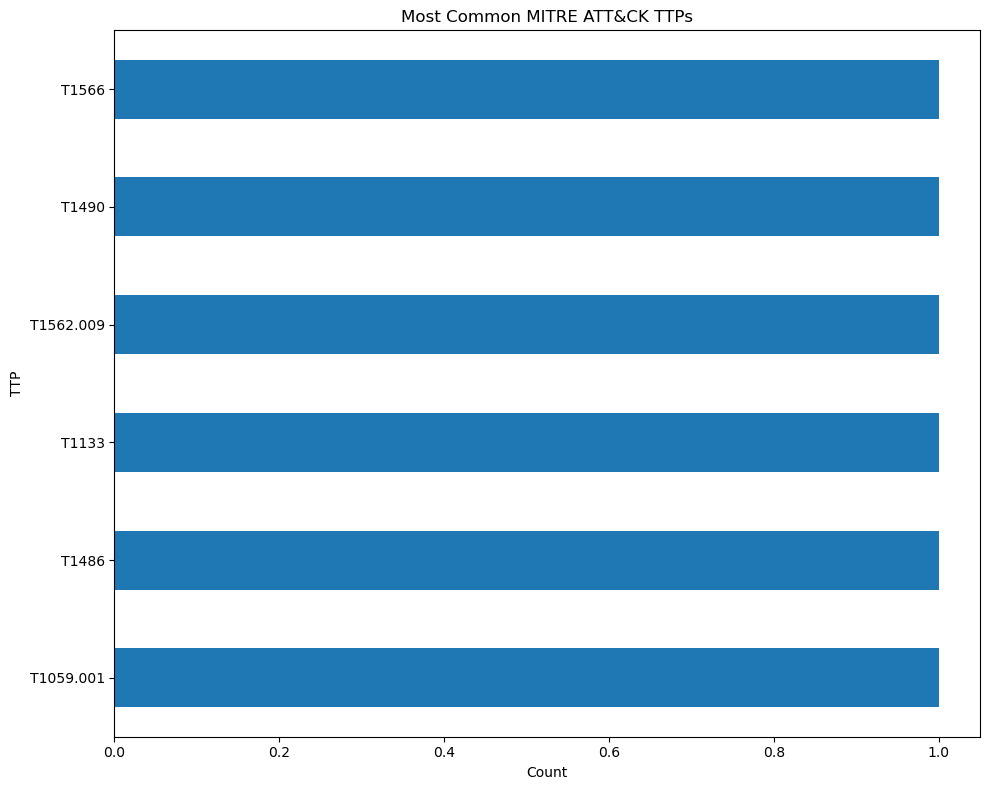

In [9]:
# Find the most common TTPs based on tags
import pandas as pd
import matplotlib.pyplot as plt

TAG = "Ransomware"

# define filters
filters = {
    'published': True,
    'threat_level_id': [1,2],
    'limit': 1000,
    'page': 1
}

# get all events in MISP instance
all_events = []
while True:
    try:
        events = misp.search(cotroller="events", **filters)
        if not events:
            break
        all_events.extend(events)
        print(f"Fetched {len(events)} events from page {filters['page']}")
        filters['page'] += 1
        if len(all_events) >= 1000:     # use filter again to control event data ingestion for execution optimization
            break
    except Exception as e:
        print(f"Error fetching events on page {filters['page']}: {e}")
        break

ttps = {                # create a dictionary containing all MITRE ATT&CK TTPs
    "T1548" : 0,
    "T1548.002" : 0,
    "T1548.004" : 0,
    "T1548.001" : 0,
    "T1548.003" : 0,
    "T1134" : 0,
    "T1134.002" : 0,
    "T1134.003" : 0,
    "T1134.004" : 0,
    "T1134.005" : 0,
    "T1134.001" : 0,
    "T1531" : 0,
    "T1087" : 0,
    "T1087.004" : 0,
    "T1087.002" : 0,
    "T1087.003" : 0,
    "T1087.001" : 0,
    "T1098" : 0,
    "T1098.001" : 0,
    "T1098.003" : 0,
    "T1098.002" : 0,
    "T1098.005" : 0,
    "T1098.004" : 0,
    "T1650" : 0,
    "T1583" : 0,
    "T1583.005" : 0,
    "T1583.002" : 0,
    "T1583.001" : 0,
    "T1583.008" : 0,
    "T1583.004" : 0,
    "T1583.007" : 0,
    "T1583.003" : 0,
    "T1583.006" : 0,
    "T1595" : 0,
    "T1595.001" : 0,
    "T1595.002" : 0,
    "T1595.003" : 0,
    "T1557" : 0,
    "T1557.002" : 0,
    "T1557.003" : 0,
    "T1557.001" : 0,
    "T1071" : 0,
    "T1071.004" : 0,
    "T1071.002" : 0,
    "T1071.003" : 0,
    "T1071.001" : 0,
    "T1010" : 0,
    "T1560" : 0,
    "T1560.003" : 0,
    "T1560.002" : 0,
    "T1560.001" : 0,
    "T1123" : 0,
    "T1119" : 0,
    "T1020" : 0,
    "T1020.001" : 0,
    "T1197" : 0,
    "T1547" : 0,
    "T1547.014" : 0,
    "T1547.002" : 0,
    "T1547.006" : 0,
    "T1547.008" : 0,
    "T1547.015" : 0,
    "T1547.010" : 0,
    "T1547.012" : 0,
    "T1547.007" : 0,
    "T1547.001" : 0,
    "T1547.005" : 0,
    "T1547.009" : 0,
    "T1547.003" : 0,
    "T1547.004" : 0,
    "T1547.013" : 0,
    "T1037" : 0,
    "T1037.002" : 0,
    "T1037.001" : 0,
    "T1037.003" : 0,
    "T1037.004" : 0,
    "T1037.005" : 0,
    "T1176" : 0,
    "T1217" : 0,
    "T1185" : 0,
    "T1110" : 0,
    "T1110.004" : 0,
    "T1110.002" : 0,
    "T1110.001" : 0,
    "T1110.003" : 0,
    "T1612" : 0,
    "T1115" : 0,
    "T1651" : 0,
    "T1580" : 0,
    "T1538" : 0,
    "T1526" : 0,
    "T1619" : 0,
    "T1059" : 0,
    "T1059.002" : 0,
    "T1059.009" : 0,
    "T1059.007" : 0,
    "T1059.008" : 0,
    "T1059.001" : 0,
    "T1059.006" : 0,
    "T1059.004" : 0,
    "T1059.005" : 0,
    "T1059.003" : 0,
    "T1092" : 0,
    "T1586" : 0,
    "T1586.003" : 0,
    "T1586.002" : 0,
    "T1586.001" : 0,
    "T1554" : 0,
    "T1584" : 0,
    "T1584.005" : 0,
    "T1584.002" : 0,
    "T1584.001" : 0,
    "T1584.004" : 0,
    "T1584.007" : 0,
    "T1584.003" : 0,
    "T1584.006" : 0,
    "T1609" : 0,
    "T1613" : 0,
    "T1136" : 0,
    "T1136.003" : 0,
    "T1136.002" : 0,
    "T1136.001" : 0,
    "T1543" : 0,
    "T1543.001" : 0,
    "T1543.004" : 0,
    "T1543.002" : 0,
    "T1543.003" : 0,
    "T1555" : 0,
    "T1555.003" : 0,
    "T1555.001" : 0,
    "T1555.005" : 0,
    "T1555.002" : 0,
    "T1555.004" : 0,
    "T1485" : 0,
    "T1132" : 0,
    "T1132.002" : 0,
    "T1132.001" : 0,
    "T1486" : 0,
    "T1565" : 0,
    "T1565.003" : 0,
    "T1565.001" : 0,
    "T1565.002" : 0,
    "T1001" : 0,
    "T1001.001" : 0,
    "T1001.003" : 0,
    "T1001.002" : 0,
    "T1074" : 0,
    "T1074.001" : 0,
    "T1074.002" : 0,
    "T1030" : 0,
    "T1530" : 0,
    "T1602" : 0,
    "T1602.002" : 0,
    "T1602.001" : 0,
    "T1213" : 0,
    "T1213.003" : 0,
    "T1213.001" : 0,
    "T1213.002" : 0,
    "T1005" : 0,
    "T1039" : 0,
    "T1025" : 0,
    "T1622" : 0,
    "T1491" : 0,
    "T1491.002" : 0,
    "T1491.001" : 0,
    "T1140" : 0,
    "T1610" : 0,
    "T1587" : 0,
    "T1587.002" : 0,
    "T1587.003" : 0,
    "T1587.004" : 0,
    "T1587.001" : 0,
    "T1652" : 0,
    "T1006" : 0,
    "T1561" : 0,
    "T1561.001" : 0,
    "T1561.002" : 0,
    "T1484" : 0,
    "T1484.002" : 0,
    "T1484.001" : 0,
    "T1482" : 0,
    "T1189" : 0,
    "T1568" : 0,
    "T1568.003" : 0,
    "T1568.002" : 0,
    "T1568.001" : 0,
    "T1114" : 0,
    "T1114.003" : 0,
    "T1114.001" : 0,
    "T1114.002" : 0,
    "T1573" : 0,
    "T1573.002" : 0,
    "T1573.001" : 0,
    "T1499" : 0,
    "T1499.003" : 0,
    "T1499.004" : 0,
    "T1499.001" : 0,
    "T1499.002" : 0,
    "T1611" : 0,
    "T1585" : 0,
    "T1585.003" : 0,
    "T1585.002" : 0,
    "T1585.001" : 0,
    "T1546" : 0,
    "T1546.008" : 0,
    "T1546.009" : 0,
    "T1546.010" : 0,
    "T1546.011" : 0,
    "T1546.001" : 0,
    "T1546.015" : 0,
    "T1546.014" : 0,
    "T1546.012" : 0,
    "T1546.016" : 0,
    "T1546.006" : 0,
    "T1546.007" : 0,
    "T1546.013" : 0,
    "T1546.002" : 0,
    "T1546.005" : 0,
    "T1546.004" : 0,
    "T1546.003" : 0,
    "T1480" : 0,
    "T1480.001" : 0,
    "T1048" : 0,
    "T1048.002" : 0,
    "T1048.001" : 0,
    "T1048.003" : 0,
    "T1041" : 0,
    "T1011" : 0,
    "T1011.001" : 0,
    "T1052" : 0,
    "T1052.001" : 0,
    "T1567" : 0,
    "T1567.002" : 0,
    "T1567.001" : 0,
    "T1567.003" : 0,
    "T1190" : 0,
    "T1203" : 0,
    "T1212" : 0,
    "T1211" : 0,
    "T1068" : 0,
    "T1210" : 0,
    "T1133" : 0,
    "T1008" : 0,
    "T1083" : 0,
    "T1222" : 0,
    "T1222.002" : 0,
    "T1222.001" : 0,
    "T1495" : 0,
    "T1187" : 0,
    "T1606" : 0,
    "T1606.002" : 0,
    "T1606.001" : 0,
    "T1592" : 0,
    "T1592.004" : 0,
    "T1592.003" : 0,
    "T1592.001" : 0,
    "T1592.002" : 0,
    "T1589" : 0,
    "T1589.001" : 0,
    "T1589.002" : 0,
    "T1589.003" : 0,
    "T1590" : 0,
    "T1590.002" : 0,
    "T1590.001" : 0,
    "T1590.005" : 0,
    "T1590.006" : 0,
    "T1590.004" : 0,
    "T1590.003" : 0,
    "T1591" : 0,
    "T1591.002" : 0,
    "T1591.001" : 0,
    "T1591.003" : 0,
    "T1591.004" : 0,
    "T1615" : 0,
    "T1200" : 0,
    "T1564" : 0,
    "T1564.008" : 0,
    "T1564.005" : 0,
    "T1564.001" : 0,
    "T1564.002" : 0,
    "T1564.003" : 0,
    "T1564.004" : 0,
    "T1564.010" : 0,
    "T1564.009" : 0,
    "T1564.006" : 0,
    "T1564.007" : 0,
    "T1574" : 0,
    "T1574.012" : 0,
    "T1574.001" : 0,
    "T1574.002" : 0,
    "T1574.004" : 0,
    "T1574.006" : 0,
    "T1574.005" : 0,
    "T1574.013" : 0,
    "T1574.007" : 0,
    "T1574.008" : 0,
    "T1574.009" : 0,
    "T1574.010" : 0,
    "T1574.011" : 0,
    "T1562" : 0,
    "T1562.008" : 0,
    "T1562.002" : 0,
    "T1562.007" : 0,
    "T1562.004" : 0,
    "T1562.001" : 0,
    "T1562.010" : 0,
    "T1562.003" : 0,
    "T1562.006" : 0,
    "T1562.009" : 0,
    "T1562.011" : 0,
    "T1525" : 0,
    "T1070" : 0,
    "T1070.003" : 0,
    "T1070.002" : 0,
    "T1070.008" : 0,
    "T1070.007" : 0,
    "T1070.009" : 0,
    "T1070.001" : 0,
    "T1070.004" : 0,
    "T1070.005" : 0,
    "T1070.006" : 0,
    "T1202" : 0,
    "T1105" : 0,
    "T1490" : 0,
    "T1056" : 0,
    "T1056.004" : 0,
    "T1056.002" : 0,
    "T1056.001" : 0,
    "T1056.003" : 0,
    "T1559" : 0,
    "T1559.001" : 0,
    "T1559.002" : 0,
    "T1559.003" : 0,
    "T1534" : 0,
    "T1570" : 0,
    "T1036" : 0,
    "T1036.007" : 0,
    "T1036.001" : 0,
    "T1036.008" : 0,
    "T1036.004" : 0,
    "T1036.005" : 0,
    "T1036.003" : 0,
    "T1036.002" : 0,
    "T1036.006" : 0,
    "T1556" : 0,
    "T1556.001" : 0,
    "T1556.007" : 0,
    "T1556.006" : 0,
    "T1556.004" : 0,
    "T1556.008" : 0,
    "T1556.002" : 0,
    "T1556.003" : 0,
    "T1556.005" : 0,
    "T1578" : 0,
    "T1578.002" : 0,
    "T1578.001" : 0,
    "T1578.003" : 0,
    "T1578.004" : 0,
    "T1112" : 0,
    "T1601" : 0,
    "T1601.002" : 0,
    "T1601.001" : 0,
    "T1111" : 0,
    "T1621" : 0,
    "T1104" : 0,
    "T1106" : 0,
    "T1599" : 0,
    "T1599.001" : 0,
    "T1498" : 0,
    "T1498.001" : 0,
    "T1498.002" : 0,
    "T1046" : 0,
    "T1135" : 0,
    "T1040" : 0,
    "T1095" : 0,
    "T1571" : 0,
    "T1003" : 0,
    "T1003.008" : 0,
    "T1003.005" : 0,
    "T1003.006" : 0,
    "T1003.004" : 0,
    "T1003.001" : 0,
    "T1003.003" : 0,
    "T1003.007" : 0,
    "T1003.002" : 0,
    "T1027" : 0,
    "T1027.001" : 0,
    "T1027.010" : 0,
    "T1027.004" : 0,
    "T1027.007" : 0,
    "T1027.009" : 0,
    "T1027.011" : 0,
    "T1027.006" : 0,
    "T1027.005" : 0,
    "T1027.002" : 0,
    "T1027.003" : 0,
    "T1027.008" : 0,
    "T1588" : 0,
    "T1588.003" : 0,
    "T1588.004" : 0,
    "T1588.005" : 0,
    "T1588.001" : 0,
    "T1588.002" : 0,
    "T1588.006" : 0,
    "T1137" : 0,
    "T1137.006" : 0,
    "T1137.001" : 0,
    "T1137.002" : 0,
    "T1137.003" : 0,
    "T1137.004" : 0,
    "T1137.005" : 0,
    "T1201" : 0,
    "T1120" : 0,
    "T1069" : 0,
    "T1069.003" : 0,
    "T1069.002" : 0,
    "T1069.001" : 0,
    "T1566" : 0,
    "T1598" : 0,
    "T1598.002" : 0,
    "T1598.003" : 0,
    "T1598.001" : 0,
    "T1566.001" : 0,
    "T1566.002" : 0,
    "T1566.003" : 0,
    "T1647" : 0,
    "T1542" : 0,
    "T1542.003" : 0,
    "T1542.002" : 0,
    "T1542.004" : 0,
    "T1542.001" : 0,
    "T1542.005" : 0,
    "T1057" : 0,
    "T1055" : 0,
    "T1055.004" : 0,
    "T1055.001" : 0,
    "T1055.011" : 0,
    "T1055.015" : 0,
    "T1055.002" : 0,
    "T1055.009" : 0,
    "T1055.013" : 0,
    "T1055.012" : 0,
    "T1055.008" : 0,
    "T1055.003" : 0,
    "T1055.005" : 0,
    "T1055.014" : 0,
    "T1572" : 0,
    "T1090" : 0,
    "T1090.004" : 0,
    "T1090.002" : 0,
    "T1090.001" : 0,
    "T1090.003" : 0,
    "T1012" : 0,
    "T1620" : 0,
    "T1219" : 0,
    "T1563" : 0,
    "T1563.002" : 0,
    "T1563.001" : 0,
    "T1021" : 0,
    "T1021.007" : 0,
    "T1021.003" : 0,
    "T1021.001" : 0,
    "T1021.002" : 0,
    "T1021.004" : 0,
    "T1021.005" : 0,
    "T1021.006" : 0,
    "T1018" : 0,
    "T1091" : 0,
    "T1496" : 0,
    "T1207" : 0,
    "T1014" : 0,
    "T1053" : 0,
    "T1053.002" : 0,
    "T1053.007" : 0,
    "T1053.003" : 0,
    "T1053.005" : 0,
    "T1053.006" : 0,
    "T1029" : 0,
    "T1113" : 0,
    "T1597" : 0,
    "T1597.002" : 0,
    "T1597.001" : 0,
    "T1596" : 0,
    "T1596.004" : 0,
    "T1596.001" : 0,
    "T1596.003" : 0,
    "T1596.005" : 0,
    "T1596.002" : 0,
    "T1593" : 0,
    "T1593.003" : 0,
    "T1593.002" : 0,
    "T1593.001" : 0,
    "T1594" : 0,
    "T1505" : 0,
    "T1505.004" : 0,
    "T1505.001" : 0,
    "T1505.005" : 0,
    "T1505.002" : 0,
    "T1505.003" : 0,
    "T1648" : 0,
    "T1489" : 0,
    "T1129" : 0,
    "T1072" : 0,
    "T1518" : 0,
    "T1518.001" : 0,
    "T1608" : 0,
    "T1608.004" : 0,
    "T1608.003" : 0,
    "T1608.005" : 0,
    "T1608.006" : 0,
    "T1608.001" : 0,
    "T1608.002" : 0,
    "T1528" : 0,
    "T1539" : 0,
    "T1649" : 0,
    "T1558" : 0,
    "T1558.004" : 0,
    "T1558.001" : 0,
    "T1558.003" : 0,
    "T1558.002" : 0,
    "T1553" : 0,
    "T1553.002" : 0,
    "T1553.006" : 0,
    "T1553.001" : 0,
    "T1553.004" : 0,
    "T1553.005" : 0,
    "T1553.003" : 0,
    "T1195" : 0,
    "T1195.003" : 0,
    "T1195.001" : 0,
    "T1195.002" : 0,
    "T1218" : 0,
    "T1218.003" : 0,
    "T1218.001" : 0,
    "T1218.002" : 0,
    "T1218.004" : 0,
    "T1218.014" : 0,
    "T1218.013" : 0,
    "T1218.005" : 0,
    "T1218.007" : 0,
    "T1218.008" : 0,
    "T1218.009" : 0,
    "T1218.010" : 0,
    "T1218.011" : 0,
    "T1218.012" : 0,
    "T1082" : 0,
    "T1614" : 0,
    "T1614.001" : 0,
    "T1016" : 0,
    "T1016.001" : 0,
    "T1049" : 0,
    "T1033" : 0,
    "T1216" : 0,
    "T1216.001" : 0,
    "T1007" : 0,
    "T1569" : 0,
    "T1569.001" : 0,
    "T1569.002" : 0,
    "T1529" : 0,
    "T1124" : 0,
    "T1080" : 0,
    "T1221" : 0,
    "T1205" : 0,
    "T1205.001" : 0,
    "T1205.002" : 0,
    "T1537" : 0,
    "T1127" : 0,
    "T1127.001" : 0,
    "T1199" : 0,
    "T1552" : 0,
    "T1552.003" : 0,
    "T1552.008" : 0,
    "T1552.005" : 0,
    "T1552.007" : 0,
    "T1552.001" : 0,
    "T1552.002" : 0,
    "T1552.006" : 0,
    "T1552.004" : 0,
    "T1535" : 0,
    "T1550" : 0,
    "T1550.001" : 0,
    "T1550.002" : 0,
    "T1550.003" : 0,
    "T1550.004" : 0,
    "T1204" : 0,
    "T1204.002" : 0,
    "T1204.003" : 0,
    "T1204.001" : 0,
    "T1078" : 0,
    "T1078.004" : 0,
    "T1078.001" : 0,
    "T1078.002" : 0,
    "T1078.003" : 0,
    "T1125" : 0,
    "T1497" : 0,
    "T1497.001" : 0,
    "T1497.003" : 0,
    "T1497.002" : 0,
    "T1600" : 0,
    "T1600.002" : 0,
    "T1600.001" : 0,
    "T1102" : 0,
    "T1102.002" : 0,
    "T1102.001" : 0,
    "T1102.003" : 0,
    "T1047" : 0,
    "T1220" : 0,
    }

# Loop through all events and increase count of a TTP in dictionary if an event has that TTP
for i in all_events:
    for tag in i['Event']['Tag']:
        if tag['name'] == TAG:
            galaxies = i['Event']['Galaxy']
        else:
            continue
        for j in galaxies:
            if j['type'] == 'mitre-attack-pattern':
                for k in j['GalaxyCluster']:
                    ttp = k['meta']['external_id'][0]
                    if ttp in ttps:
                        ttps[ttp] += 1

# plot data
print("Top Tag Counts:", {k: v for k, v in sorted(ttps.items(), key=lambda x: x[1], reverse=True)[:10]})
ttps_data = pd.Series(data=ttps, index=list(ttps.keys()))
filtered_ttps = ttps_data[ttps_data >= 1].sort_values(ascending=True)

if not filtered_ttps.empty:
    filtered_ttps.plot.barh(figsize=(10, 8), color='#1f77b4')
    plt.title('Most Common MITRE ATT&CK TTPs')
    plt.xlabel('Count')
    plt.ylabel('TTP')
    plt.tight_layout()
    plt.show()
else:
    print("No TTPs with count >= 1 found.")

In [ ]:
# Get a list of IOCs from MISP which can be added to an IDS systems to block/alert

def get_misp_attributes(misp_url, misp_api_key, days=7, limit=1000, ssl=False):
    
    try:
        # Search for attributes with IDS flag
        print(f"Searching for attributes from last {days} days (limit: {limit})...")
        
        attributes = misp.search(
            controller='attributes',
            to_ids=1,
            pythonify=True,
            publish_timestamp=f'{days}d',
            limit=limit
        )
        
        print(f"Found {len(attributes)} attributes")
        
        # define indicators
        indicators = {
            "ipv4": [],
            "ipv6": [],
            "domain": [],
            "url": [],
            "sha256": [],
            "sha1": [],
            "md5": []
        }
        
        for attr in attributes:
            try:
                attr_type = attr.type
                attr_value = attr.value
                
                # Categorize by type
                if attr_type in ['ip-dst', 'ip-src']:
                    if ':' in attr_value:
                        indicators["ipv6"].append(attr_value)
                    else:
                        indicators["ipv4"].append(attr_value)
                elif attr_type == 'domain':
                    indicators["domain"].append(attr_value)
                elif attr_type == 'url':
                    indicators["url"].append(attr_value)
                elif attr_type == 'sha256':
                    indicators["sha256"].append(attr_value)
                elif attr_type == 'sha1':
                    indicators["sha1"].append(attr_value)
                elif attr_type == 'md5':
                    indicators["md5"].append(attr_value)
                    
            except Exception as e:
                continue

        # Print summary
        print("\n=== Indicators Summary ===")
        total_indicators = 0
        for ioc_type, values in indicators.items():
            count = len(values)
            print(f"{ioc_type.upper()}: {count} indicators")
            total_indicators += count
        
        print(f"TOTAL: {total_indicators} unique indicators")
        
        return indicators
        
    except Exception as e:
        print(f"Error: {e}")
        return None

def print_indicators_sample(indicators, sample_size=5):
    if not indicators:
        print("No indicators to display")
        return
    
    print(f"\n=== Sample Indicators (showing up to {sample_size} each) ===")
    
    for ioc_type, values in indicators.items():
        if values:
            print(f"\n{ioc_type.upper()}:")
            for i, value in enumerate(values[:sample_size]):
                print(f"  {i+1}. {value}")
            if len(values) > sample_size:
                print(f"  ... and {len(values) - sample_size} more")

# Usage Example
if __name__ == "__main__":
    
    indicators = get_misp_attributes(
        misp_url=MISP_URL,
        misp_api_key=MISP_API_KEY,
        days=30,        # change the days will show different numbers of IOC results for all types
        limit=8000,
        ssl=False
    )
    
    if indicators:
        print_indicators_sample(indicators, sample_size=3)

Searching for attributes from last 30 days (limit: 8000)...
Found 8000 attributes

=== Indicators Summary ===
IPV4: 3212 indicators
IPV6: 0 indicators
DOMAIN: 240 indicators
URL: 936 indicators
SHA256: 1294 indicators
SHA1: 698 indicators
MD5: 535 indicators
TOTAL: 6915 unique indicators

=== Sample Indicators (showing up to 3 each) ===

IPV4:
  1. 104.223.120.159
  2. 117.184.105.34
  3. 101.36.121.4
  ... and 3209 more

DOMAIN:
  1. ameteksen.com
  2. assso.net
  3. caref1rst.com
  ... and 237 more

URL:
  1. from-white/[0.01]
  2. ic/chunks/1329d575-b354c3e5a8c9ab87.js\
  3. tatic/chunks/b536a0f1-f5db2910e950ab99.js\
  ... and 933 more

SHA256:
  1. 75b6ce7907cae18983817c1b85824c2d4989d2c93dbbcce05790166c68de5f32
  2. 9ed5eda8a7e6a676cc2006899967e221c78e8f3ba2514546f2f3e9376940bc52
  3. cc7b9fa24c99933abce25356c8ec96c906c50304c19cec9e8d71624f5f155fe2
  ... and 1291 more

SHA1:
  1. af364ff503da71875b6d7c401a1e98e31450a561
  2. db2b8f49b4e76c2f538a3a6b222c35547c802cef
  3. 29968b0c41